In [1]:
import numpy as np
import pandas as pd
import sqlite3
import json

import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim 
import folium

## Load `places` db with radar scanning


In [62]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("nyc_large_places_20210317_114749.db")
df = pd.read_sql_query("SELECT id, name from places", con)

print(df.shape)

# Verify that result of SQL query is stored in the dataframe
df.head()

(9453, 2)


,id,name
0,ChIJDbzqHhXFw4kR5dCbhMQVy7Q,Dideriksen Park
1,ChIJy-IrJHjFw4kRxAxQnEhKzKA,East Brunswick Community Garden
2,ChIJO5COJz3Fw4kRQxVRafcYWpw,East Brunswick Dog Park
3,ChIJfV8duHfFw4kR8bYChN8sXK4,Veterans Park
4,ChIJyYBB1xrFw4kRtlJq8t5WDVg,Tennis Park


In [63]:
cur = con.cursor()
row = cur.execute("SELECT COUNT(DISTINCT id) FROM places")
list(row)

[(7725,)]

In [4]:
def extract_feature(value, name, default=None):
    content = json.loads(value)
    return content.get(name, default)

In [6]:
def extract_location(value, default=None):
    content = json.loads(value)
    geo = content.get('geometry', default)
    if geo:
        location = geo.get('location', default)
        if location:
            coords = (location['lat'], location['lng'])
    else:
        coords = default
    return coords

In [64]:
df_content = pd.read_sql_query("SELECT data from places", con)
con.close()

df_content.shape

(9453, 1)

In [65]:
# extract some of features from data blob
df['rating'] = df_content.data.apply(extract_feature, args=('rating',), default=None)

df['user_ratings_total'] = df_content.data.apply(extract_feature, args=('user_ratings_total',), default=None)

df['geometry'] = df_content.data.apply(extract_location, default=None)

In [66]:
df['lat'] = df['geometry'].apply(lambda x: x[0])
df['lng'] = df['geometry'].apply(lambda x: x[1])
df

,id,name,rating,user_ratings_total,geometry,lat,lng
0,ChIJDbzqHhXFw4kR5dCbhMQVy7Q,Dideriksen Park,4.5,83.0,"(40.4027413, -74.4309456)",40.402741,-74.430946
1,ChIJy-IrJHjFw4kRxAxQnEhKzKA,East Brunswick Community Garden,4.7,18.0,"(40.4175543, -74.41711289999999)",40.417554,-74.417113
2,ChIJO5COJz3Fw4kRQxVRafcYWpw,East Brunswick Dog Park,4.4,80.0,"(40.4000221, -74.4400141)",40.400022,-74.440014
3,ChIJfV8duHfFw4kR8bYChN8sXK4,Veterans Park,5.0,2.0,"(40.41824039999999, -74.41958629999999)",40.418240,-74.419586
4,ChIJyYBB1xrFw4kRtlJq8t5WDVg,Tennis Park,NaN,NaN,"(40.4124101, -74.4435864)",40.412410,-74.443586
...,...,...,...,...,...,...,...
9448,ChIJ9c-rLewN6IkR_-3N0LUxHIk,Peacock Pavilion,NaN,NaN,"(41.211016, -73.1813451)",41.211016,-73.181345
9449,ChIJPR8jmRYN6IkRXZtWg8zC1dI,Sculpture Garden,NaN,NaN,"(41.2099825, -73.18159650000001)",41.209983,-73.181597
9450,ChIJOYxu8vwL6IkRjJBvNc92Wsc,Trumbull Park,NaN,NaN,"(41.2351244, -73.1779864)",41.235124,-73.177986
9451,ChIJuaYD8qYL6IkRk72zQkXhGOA,Twin Brooks Park - Parking Lot,5.0,2.0,"(41.246904, -73.18213779999999)",41.246904,-73.182138


### inspect the log to see if smaller circle radar is needed
Extract rows in log started from "warning"

In [55]:
log_name = 'runlogs/fetch_20210317_114749_nyc_large.log'
# log_name = 'runlogs/fetch_20210316_120447_philly.log'
with open(log_name, 'r') as f:
    lines = f.readlines()

In [57]:
# get log warning
log_warning = [x for x in lines if x.startswith('WARNING:')]

#log_warning

In [58]:
import re
# extract coords from warning
r_warning = r'\[(.+), (.+), \d+\]'
coords_warning = [(float(re.search(r_warning, warning).group(1)), float(re.search(r_warning, warning).group(2))) 
 for warning in log_warning]

In [60]:
# visualize these coords
geolocator = Nominatim(user_agent="nyc_explorer")

# address = 'Philadelphia, PA'
address = 'New York City, NY'

location = geolocator.geocode(address)
latitude_nyc = location.latitude
longitude_nyc = location.longitude

# create map of Toronto using latitude and longitude values

map_nyc = folium.Map(location=[latitude_nyc, longitude_nyc], zoom_start=11)

# add markers to map
for lat, lng in coords_warning:
    if ~np.isnan(lat):
        folium.CircleMarker(
            [lat, lng], radius=5, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, 
            parse_html=False).add_to(map_nyc)  
    
map_nyc

## thus scanned another round with smaller circles, now combine the two

In [69]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("nyc_small_places_20210317_130850.db")
df_small = pd.read_sql_query("SELECT id, name FROM places", con)

print(df_small.shape)

(2740, 2)


In [70]:
df_small_content = pd.read_sql_query("SELECT data from places", con)
con.close()

In [71]:
# extract some of features from data blob
df_small['rating'] = df_small_content.data.apply(extract_feature, args=('rating',), default=None)

df_small['user_ratings_total'] = df_small_content.data.apply(extract_feature, args=('user_ratings_total',), default=None)

df_small['geometry'] = df_small_content.data.apply(extract_location, default=None)
df_small['lat'] = df_small['geometry'].apply(lambda x: x[0])
df_small['lng'] = df_small['geometry'].apply(lambda x: x[1])
df_small

,id,name,rating,user_ratings_total,geometry,lat,lng
0,ChIJe8G-54xRwokRLzLvOgu1Sn4,Liberty State Park Walk-way,5.0,3.0,"(40.7054421, -74.0401473)",40.705442,-74.040147
1,ChIJZQU_F69QwokRwfccf_-oM4I,Paulus Hook Park,3.5,52.0,"(40.715017, -74.037415)",40.715017,-74.037415
2,ChIJeewYrqVQwokRRAXnpcUS8TQ,Morris Canal Park,4.5,287.0,"(40.7116816, -74.0377456)",40.711682,-74.037746
3,ChIJ6YJb46VQwokRGapdi-Gn8DU,General Nathanael Greene Park,4.5,68.0,"(40.71253919999999, -74.0363466)",40.712539,-74.036347
4,ChIJlyOHBplRwokRfskJI910Zuw,Paulus Hook Fairy Garden,NaN,NaN,"(40.71400860000001, -74.0393122)",40.714009,-74.039312
...,...,...,...,...,...,...,...
2735,ChIJi4X3yO5fwokR6GMMcWCyaok,Flushing Bay Promenade,NaN,NaN,"(40.759738, -73.8527071)",40.759738,-73.852707
2736,ChIJi4X3yO5fwokR6GMMcWCyaok,Flushing Bay Promenade,NaN,NaN,"(40.759738, -73.8527071)",40.759738,-73.852707
2737,ChIJm069OC71wokRlwo13Wmhmh4,Clason Point Park,4.5,746.0,"(40.8055473, -73.84815859999999)",40.805547,-73.848159
2738,ChIJOU0gfin1wokR_HujcSJFJKg,Castle Hill Park,4.3,199.0,"(40.81273069999999, -73.84780289999999)",40.812731,-73.847803


In [72]:
# merge the two dfs, drop the ones without rating and the ones duplicated
df_all = pd.concat((df, df_small), axis=0).dropna(axis=0).drop_duplicates(subset=['id'])
df_all

,id,name,rating,user_ratings_total,geometry,lat,lng
0,ChIJDbzqHhXFw4kR5dCbhMQVy7Q,Dideriksen Park,4.5,83.0,"(40.4027413, -74.4309456)",40.402741,-74.430946
1,ChIJy-IrJHjFw4kRxAxQnEhKzKA,East Brunswick Community Garden,4.7,18.0,"(40.4175543, -74.41711289999999)",40.417554,-74.417113
2,ChIJO5COJz3Fw4kRQxVRafcYWpw,East Brunswick Dog Park,4.4,80.0,"(40.4000221, -74.4400141)",40.400022,-74.440014
3,ChIJfV8duHfFw4kR8bYChN8sXK4,Veterans Park,5.0,2.0,"(40.41824039999999, -74.41958629999999)",40.418240,-74.419586
7,ChIJH69WSN3Fw4kR-7avD3gy0jo,Milltown Little League,3.5,4.0,"(40.45082839999999, -74.4326365)",40.450828,-74.432637
...,...,...,...,...,...,...,...
2545,ChIJ7bPTCvn0wokROPKMzgI5kYg,Bronx River Trail,4.3,3.0,"(40.82749, -73.88501699999999)",40.827490,-73.885017
2551,ChIJfTP2N_H0wokRSK-jDqj16IU,Starlight Park,4.4,482.0,"(40.8335727, -73.88248469999999)",40.833573,-73.882485
2552,ChIJfb4rltn1wokRwtzhQ6GDa2w,Bronx River Greenway,4.1,8.0,"(40.83322, -73.8820921)",40.833220,-73.882092
2580,ChIJERkYm33zwokRCmYY7vCuFPY,Everett Garden Gate,4.6,98.0,"(40.8596436, -73.8806373)",40.859644,-73.880637


(array([1267., 1162., 1313., 1215.,  676.,  289.,   92.,   23.,    9.,
           2.]),
 array([ 0.        ,  1.22667396,  2.45334792,  3.68002189,  4.90669585,
         6.13336981,  7.36004377,  8.58671773,  9.8133917 , 11.04006566,
        12.26673962]),
 <a list of 10 Patch objects>)

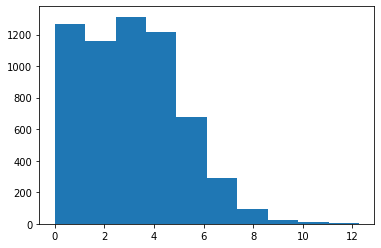

In [76]:
plt.hist(np.log(df_all['user_ratings_total']))

### save the clean ids
for a second round of popularity queries

In [73]:
# distinct_conn = sqlite3.connect("cleaned_nyc_places_20210317_114749.db")
# df_all.drop(columns=['geometry']).to_sql('places', distinct_conn)
# distinct_conn.close()

## Load popularity database to identify the ones with `popular times` for further data collection


In [80]:
con = sqlite3.connect('nyc_popularity_20210317_133549.db')
cursor = con.cursor()

print('total number of entries: ' + str(list(cursor.execute("SELECT COUNT(*) FROM popularity"))))

pop_df = pd.read_sql_query("SELECT id, name, address, has_popular_times, curr_popularity from popularity WHERE has_popular_times > 0", con)
pop_df


total number of entries: [(6048,)]


,id,name,address,has_popular_times,curr_popularity
0,ChIJDbzqHhXFw4kR5dCbhMQVy7Q,Dideriksen Park,"Fern Rd, East Brunswick, NJ 08816, USA",1,-1
1,ChIJO5COJz3Fw4kRQxVRafcYWpw,East Brunswick Dog Park,"Dunhams Corner Rd, East Brunswick, NJ 08816, USA",1,-1
2,ChIJM29CK8PFw4kRWZIbxcestzo,Gloria Bradford Borough Park,"80 Violet Terrace, Milltown, NJ 08850, USA",1,-1
3,ChIJnQ9L1fPFw4kRZ7FelqVzLP4,Country Lane Park,"20 Wedgewood Ct, East Brunswick, NJ 08816, USA",1,-1
4,ChIJKw0kXxHGw4kRn0bEGob21as,Rutgers Gardens,"112 Log Cabin Rd, North Brunswick Township, NJ...",1,-1
...,...,...,...,...,...
2812,ChIJ45Y73YD0wokR6x0q6cvzpEI,Ciccarone Park,"2426 Hughes Ave, The Bronx, NY 10458, USA",1,-1
2813,ChIJueLtN4DzwokRJWO2gJPSH2I,Rose Hill Park,"4270, 2659 Webster Ave, The Bronx, NY 10458, USA",1,-1
2814,ChIJfTP2N_H0wokRSK-jDqj16IU,Starlight Park,"1490 Sheridan Blvd., The Bronx, NY 10459, USA",1,71
2815,ChIJfb4rltn1wokRwtzhQ6GDa2w,Bronx River Greenway,"1490 Sheridan Blvd., The Bronx, NY 10459, USA",1,-1


In [81]:
pop_df_detail = pd.read_sql_query("SELECT details FROM popularity WHERE has_popular_times > 0", con)
pop_df_detail.head()
con.close()

In [82]:
pop_df[pop_df['curr_popularity']>-1]

,id,name,address,has_popular_times,curr_popularity
5,ChIJKYT7QWbGw4kRhuv9Yv5_oVk,Recreation Park,"New Brunswick, NJ 08901, USA",1,78
6,ChIJe0JPXDfGw4kR_gaExaQxbPA,Donaldson Park,"526 S 2nd Ave, Highland Park, NJ 08904, USA",1,42
11,ChIJK1EV_DDGw4kRiVLbWRb960Y,Donaldson Dog Park,"5 Parkview Terrace, Highland Park, NJ 08904, USA",1,10
14,ChIJm9ZW62y4w4kR_1GXdHDdVV8,Ocean State Job Lot,"6305 Hadley Rd, South Plainfield, NJ 07080, USA",1,25
36,ChIJz8e2vVbPw4kRBOANAu28lJw,Lowe's Garden Center,"339 State Highway Route 18, East Brunswick, NJ...",1,38
...,...,...,...,...,...
2777,ChIJeXV04gZcwokRG0oDvhofLtY,Green Central Knoll,"55-65 Evergreen Ave, Brooklyn, NY 11206, USA",1,12
2786,ChIJh8E3XTL0wokRooNttlAWr5s,Joyce Kilmer Park,"955 Walton Ave, The Bronx, NY 10452, USA",1,40
2801,ChIJX5bU2EX0wokRUlxEpveM7bA,Central Parck,"Park Ave, The Bronx, NY 10458, USA",1,71
2810,ChIJ6Qg0N_n0wokRctu0TLzFcHw,Concrete Plant Park,"Westchester Ave, The Bronx, NY 10472, USA",1,53


In [96]:
def extract_postal_code(value, default=None):
    content = json.loads(value)
    postal_code = default
    try:
        if content['address_components']:
            postal_code = [content['address_components'][i]['short_name'] for i in range(len(content['address_components'])) 
             if content['address_components'][i]['types'][0]=='postal_code'][0]
    except:
        print(content['place_id'])
    return postal_code

In [95]:
json.loads(pop_df_detail['details'].iloc[0])['address_components']

[{'long_name': 'Fern Road', 'short_name': 'Fern Rd', 'types': ['route']},
 {'long_name': 'East Brunswick',
  'short_name': 'East Brunswick',
  'types': ['locality', 'political']},
 {'long_name': 'Middlesex County',
  'short_name': 'Middlesex County',
  'types': ['administrative_area_level_2', 'political']},
 {'long_name': 'New Jersey',
  'short_name': 'NJ',
  'types': ['administrative_area_level_1', 'political']},
 {'long_name': 'United States',
  'short_name': 'US',
  'types': ['country', 'political']},
 {'long_name': '08816', 'short_name': '08816', 'types': ['postal_code']}]

In [97]:
pop_df['postal_code'] = pop_df_detail['details'].apply(extract_postal_code)

ChIJQwRohxBbwokRmHrfAMb3ixc
ChIJ4zGFAZpYwokRGUGph3Mf37k
ChIJL1DP2C72wokRh3Lfn4T0Z3w
ChIJVWnMscTT6YkRU7Ua05Yx6Eg


In [111]:
pop_df[pop_df['id']=='ChIJVWnMscTT6YkRU7Ua05Yx6Eg']

,id,name,address,has_popular_times,curr_popularity,postal_code
2537,ChIJVWnMscTT6YkRU7Ua05Yx6Eg,Cedar Beach Marina,"Babylon, NY, USA",1,-1,None


In [113]:
json.loads(pop_df_detail['details'].iloc[2537])['address_components']

[{'long_name': 'United States',
  'short_name': 'US',
  'types': ['country', 'political']},
 {'long_name': 'Babylon',
  'short_name': 'Babylon',
  'types': ['administrative_area_level_3', 'political']},
 {'long_name': 'Suffolk County',
  'short_name': 'Suffolk County',
  'types': ['administrative_area_level_2', 'political']},
 {'long_name': 'New York',
  'short_name': 'NY',
  'types': ['administrative_area_level_1', 'political']}]

### save the task_list db for scrapping accross time

In [112]:
# task_conn = sqlite3.connect("selected_nyc_places_20210317_133549.db")
# pop_df.to_sql('task_list', task_conn)
# task_conn.close()